In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = 0, xmax = 0):
    plt.grid(True)
    plt.plot(x, y, "o")
    k, b = mnk_non_zero(x, y)
    xl = np.array([min(x.min(), xmin), max(xmax, x.max())])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
        
    
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:167: SyntaxWarning: invalid escape sequence '\p'
<>:170: SyntaxWarning: invalid escape sequence '\p'
<>:172: SyntaxWarning: invalid escape sequence '\p'
<>:172: SyntaxWarning: invalid escape sequence '\c'
<>:175: SyntaxWarning: invalid escape sequence '\p'
<>:167: SyntaxWarning: invalid escape sequence '\p'
<>:170: SyntaxWarning: invalid escape sequence '\p'
<>:172: SyntaxWarning: invalid escape sequence '\p'
<>:172: SyntaxWarning: invalid escape sequence '\c'
<>:175: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_28374/359819690.py:167: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
/tmp/ipykernel_28374/359819690.py:170: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
/tmp/ipykernel_28374/359819690.py:172: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
/tmp/ipykernel_28374/359819690.py:172: SyntaxWarning: invalid escape sequence '\c'
  return 

Выполним исследование простого поиска


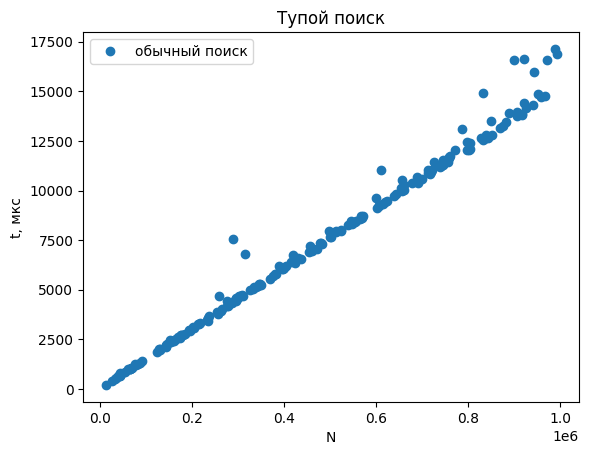

In [43]:
plt.xlabel("N")
plt.ylabel("t, мкс")
data1 = pd.read_csv("simpl_poisk.csv")
plt.plot(data1["N"], data1["t"], "o", label = "обычный поиск")
plt.title("Тупой поиск")
plt.legend()

Выполним исследование бинарного поиска


Text(0.5, 1.0, 'Бинарный поиск')

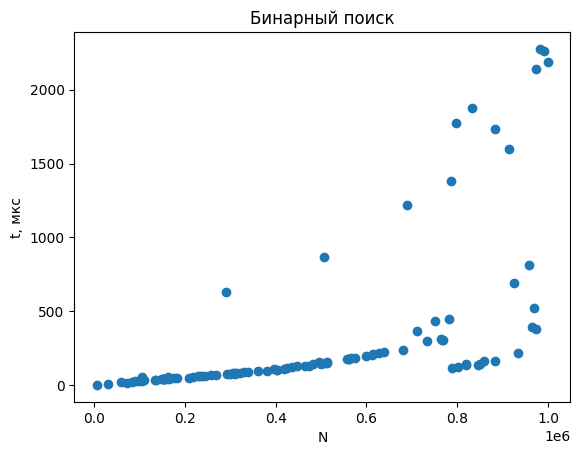

In [51]:
plt.xlabel("N")
plt.ylabel("t, мкс")
data1 = pd.read_csv("bin_poisk.csv")
plt.plot((data1["N"]), (data1["t"]), "o")
plt.title("Бинарный поиск")

На логарифм не похоже, а вот на прямую вполне

k, b = $1.272 \pm 0.076$ $-11.39 \pm 0.97$


Text(0.5, 1.0, 'Бинарный поиск логарифмический')

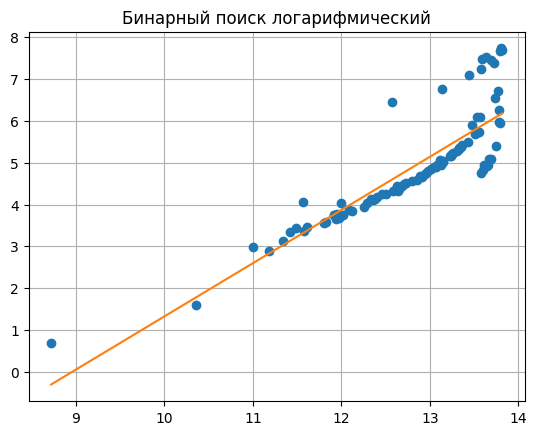

In [52]:
k, b = linearcalc(np.log(data1["N"]), np.log(data1["t"]), 10)
plt.title("Бинарный поиск логарифмический")

Поиск суммы получился вполне адеватным

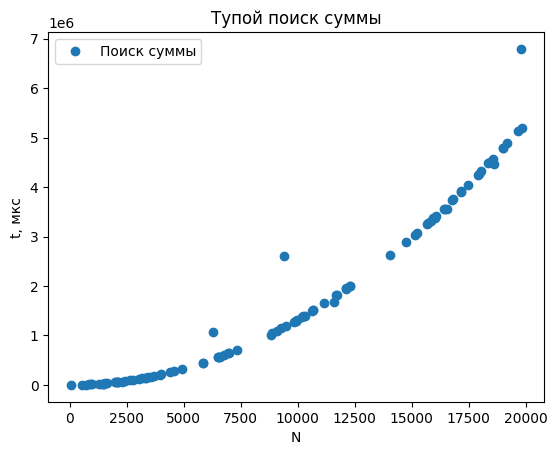

In [46]:
plt.xlabel("N")
plt.ylabel("t, мкс")
data_sum= pd.read_csv("sum_poisk.csv")
plt.plot(data_sum["N"], data_sum["t"], "o", label = "Поиск суммы")
plt.title("Тупой поиск суммы")
plt.legend()

Реально порабола, жесть

k, b = $2.043 \pm 0.012$ $-4.70 \pm 0.10$


Text(0.5, 1.0, 'Тупой поиск суммы логарифмический')

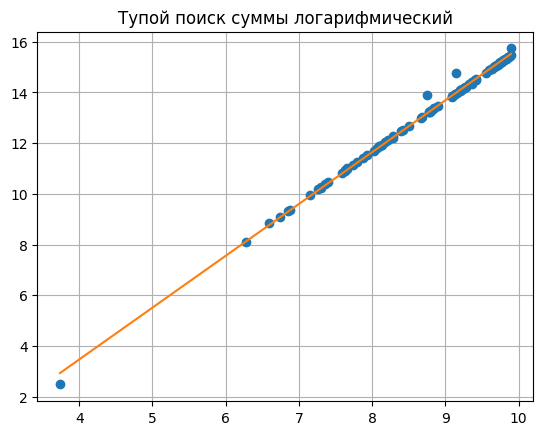

In [47]:
k, b = linearcalc(np.log(data_sum["N"]), np.log(data_sum["t"]), 10)
plt.title("Тупой поиск суммы логарифмический")

Поиск суммы для упорядоченного это внезапно прямая

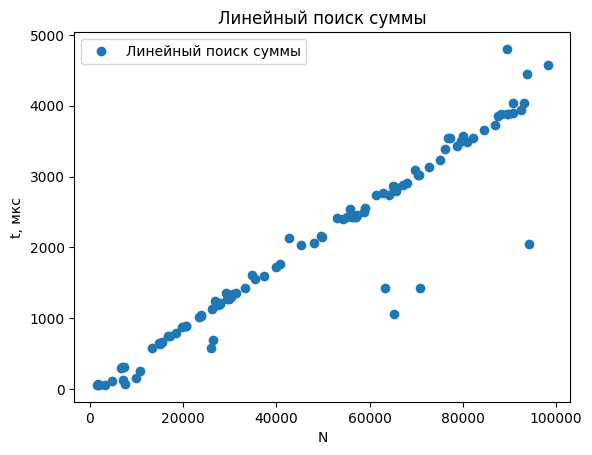

In [48]:
plt.xlabel("N")
plt.ylabel("t, мкс")
data_sum_bin= pd.read_csv("sum_poisk_bin.csv")
plt.plot(data_sum_bin["N"], data_sum_bin["t"], "o", label = "Линейный поиск суммы")
plt.title("Линейный поиск суммы")
plt.legend()

Теперь жесть какая-то. Вот эти хитрые алгоритмы поиска не работают нифига

In [49]:
def data_srez(data, bookva, ravnomerno):
    data_bookva = data[data["bookva"] == bookva]
    return data_bookva[data_bookva["ravnomerno"] == ravnomerno]

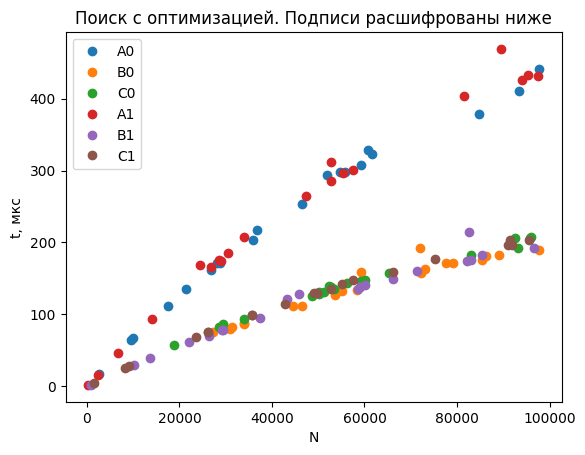

In [50]:
plt.xlabel("N")
plt.ylabel("t, мкс")
data_smart= pd.read_csv("smart_poisk.csv")
data_smart_A0 = data_srez(data_smart, "A", 0)
data_smart_B0 = data_srez(data_smart, "B", 0)
data_smart_C0 = data_srez(data_smart, "C", 0)
data_smart_A1 = data_srez(data_smart, "A", 1)
data_smart_B1 = data_srez(data_smart, "B", 1)
data_smart_C1 = data_srez(data_smart, "C", 1)

plt.plot(data_smart_A0["N"], data_smart_A0["t"], "o", label = "A0")
plt.plot(data_smart_B0["N"], data_smart_B0["t"], "o", label = "B0")
plt.plot(data_smart_C0["N"], data_smart_C0["t"], "o", label = "C0")
plt.plot(data_smart_A1["N"], data_smart_A1["t"], "o", label = "A1")
plt.plot(data_smart_B1["N"], data_smart_B1["t"], "o", label = "B1")
plt.plot(data_smart_C1["N"], data_smart_C1["t"], "o", label = "C1")

plt.title("Поиск с оптимизацией. Подписи расшифрованы ниже")

plt.legend()

Кошмар какой-то. Буквы ABC - тип поиска. 1 - равномерное распределение, 0 - смешение значений для поиска